<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/Assignment_2_LDA%2BSIFT_Christian_Peluso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Utils
import os
import zipfile
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

!gdown --id "1-rCo9m41qlH9f8KHqhZ0qG_C-6YCDp3N&confirm=t"

with zipfile.ZipFile( "/content/dataset.zip", 'r') as zips:
  zips.extractall( '/content/')

def plot_grids(folder):
  classes = {
      1: 'Grass',
      2: 'Tree',
      3: 'Building', 
      4:'Airplane', 
      5:'Cow', 
      6:'Human Face',
      7: 'Car',
      8: 'Bycicle'
  }
  fig = plt.figure(figsize=(22, 10))
  rows = 2
  columns = 8
  for i, c in enumerate(classes.keys()):
    img = cv.imread('dataset/' + str(c) + '_2_s.bmp')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(str(classes[c]))

  # reading result images
  for i, c in enumerate(classes.keys()):
    img = cv.imread(str(folder) + '/' + str(c) + '_2_s.jpg')
    fig.add_subplot(rows, columns, i+columns+1)
    plt.imshow(img)
    plt.axis('off')

def target_generator():
  y=[range]
  for i in range(240):
    y.append(i//30)
  return y[1:]

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-rCo9m41qlH9f8KHqhZ0qG_C-6YCDp3N&confirm=t
To: /content/dataset.zip
100% 43.9M/43.9M [00:00<00:00, 79.3MB/s]


## Detection and Description

Here we will use the OpenCV method called **ORB** in order to *detect* interesting points among the image, then we will take advantage of the simplicity but useful Gaussian difference *description* of the **SIFT** in order to gather our patches among the dataset.

In [ ]:
descriptors=[]
KP_IMAGE=100
if not os.path.exists('results'):
    os.makedirs('results')
dataset_imgs = os.listdir("dataset")
orb = cv.ORB_create()
sift = cv.SIFT_create(0, 3, 0.04, 8, 1.6)
for img_name in dataset_imgs:
  if "GT" not in img_name:
    img = cv.imread('dataset/'+img_name)
    kp = orb.detect(img,None)
    kp_s, des = sift.compute(img, kp[:KP_IMAGE])
    descriptors.append(des)
    image=cv.drawKeypoints(img,kp_s,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    cv.imwrite('results/'+img_name.replace('.bmp','.jpg'),image)

Since the descriptors for the ORB module are expressed in 32 int vectors, we are recomputing the description of the KeyPoints thanks to SIFT that has a better gradient description `4 × 4` (the dimension of window in which the gradient are computed) `× 8` (the directions admissible for the gradients).

In [ ]:
len(descriptors[0][0]) # Before the ORB descriptors had a length of 32

128

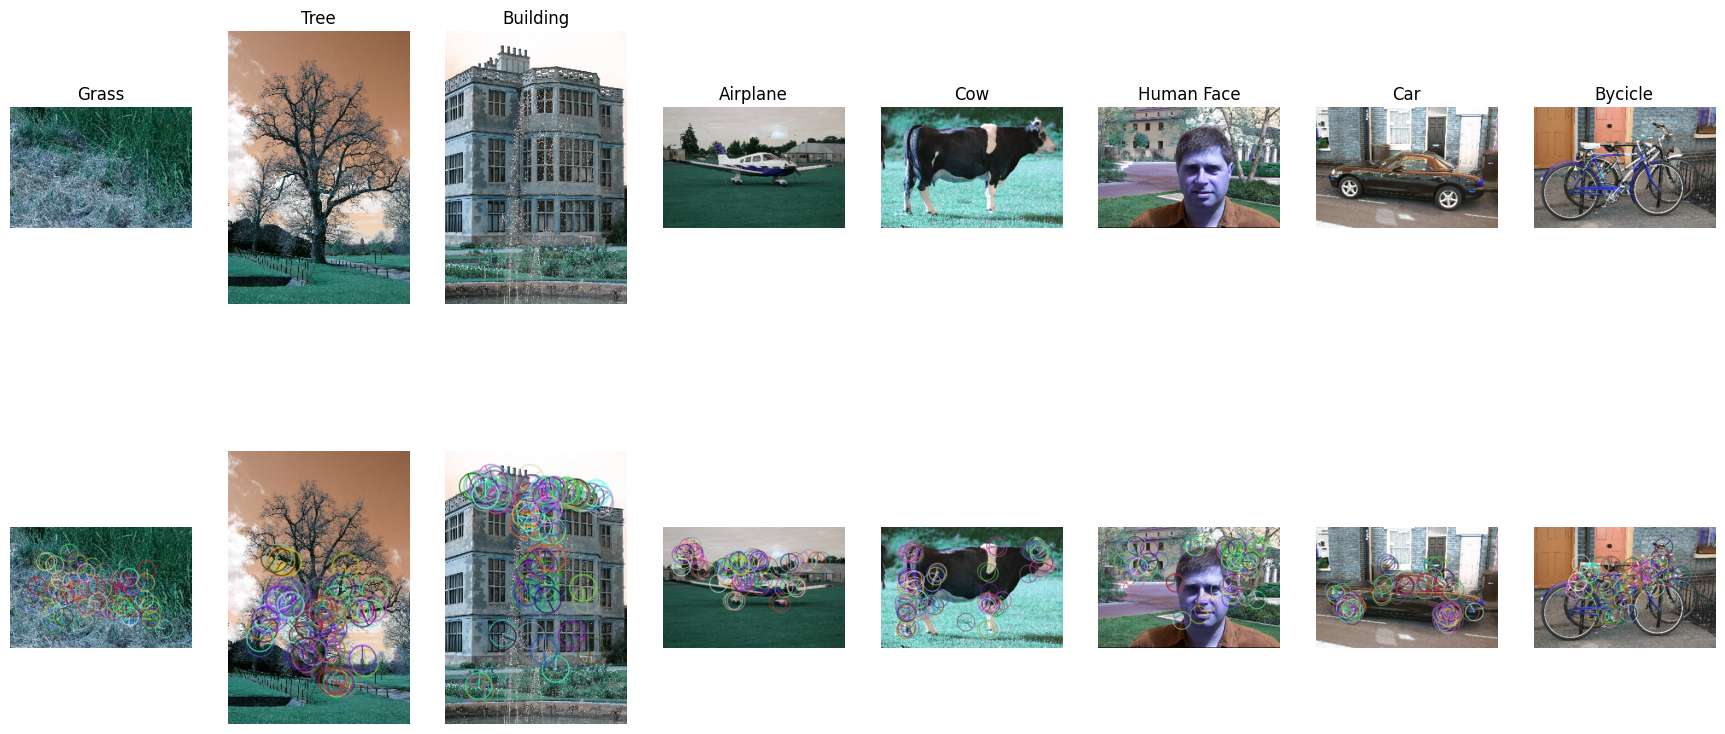

In [ ]:
plot_grids('results')

As we can see the math is correct and the list of descriptor is fulfilled with the SIFT descriptors of length 128. As we have selected only 100 KeyPoints for each image and since our dataset has a lenght of 240 images we will have 240 × 100 interesting points, too many for our purposes of classification. That's why we will go to create a simpler set, clusterizing the points in far less regions.

In [ ]:
# For each image SIFT express the descriptor in 128 bin values, so we can stack 
# all the descriptors in a matrix so we will have bin * descriptors tensor
print(len(descriptors[0])) # We have 100 descriptor per each image
des_tensor = np.vstack(descriptors)
print(f'The 1st dimension is the length of the patches')
print(f'instead the 2nd is the length of each descriptor: {des_tensor.shape}')

100
The 1st dimension is the length of the patches
instead the 2nd is the length of each descriptor: (24000, 128)


## Cluster method selection

Here we are trying to detect what is the best tradeoff of components to shrink our patches.

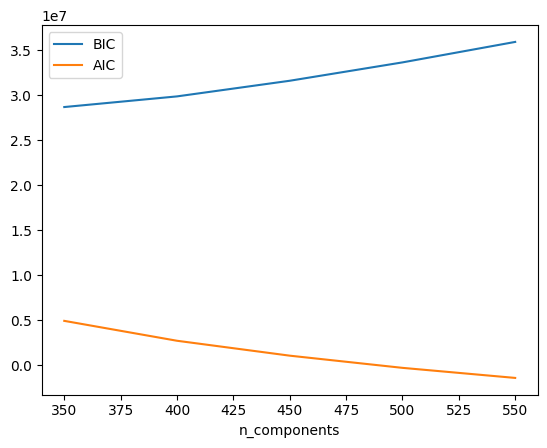

In [ ]:
%%timeit
from sklearn.mixture import GaussianMixture as GMM
n_components = np.arange(350, 600, 50)
models = [GMM(n, covariance_type='spherical', random_state=0, max_iter=100).fit(des_tensor)
          for n in n_components]

plt.plot(n_components, [m.bic(des_tensor) for m in models], label='BIC')
plt.plot(n_components, [m.aic(des_tensor) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

From the plot of the Akaike and Bayesian Information Criterion metrics we can see that the best trade off between empirical risk and complexity is around the 400th components. So we will train some models with those number of clusters and then we will test the capacity of the Classifier.

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
gmm_model = GMM(400, covariance_type='full', random_state=0, max_iter=200).fit(des_tensor)

In [ ]:
print(f'The Bayesian Information Criterion is: {gmm_model.bic(des_tensor)}')
print(f'The Akaike   Information Criterion is: {gmm_model.aic(des_tensor)}')

The Bayesian Information Criterion is: 29898717.241010327
The Akaike   Information Criterion is: 2778921.574126345


### Vocabulary creation

Now we take advantage of the clusters in order to shrink the sparsity of the descriptors in a more comfortable dimension.

In [ ]:
vocabulary = [gmm_model.predict(des_tensor[100*i:100*(i+1)]) 
              for i in range(0, 240)]

In [ ]:
test = [vocabulary.pop(i*30)
        for i in range(0,8)] # We take out the last image for each subset of topics

# LDA topic extraction from the whole image

Here we are trying to use the LDA directly as a classifier fitting the graph on images (documents) that contains 100 patches (words) per each (so the data reduction performed on each descriptor of len 128) ∈ [0, 399].

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=14, # I've selected 14 components because the 8  subset of topics contains also noise and other kind of image segments
    random_state=0)
lda.fit(vocabulary)

# get topics for some given samples:
lda.transform(vocabulary[-2:])

array([[3.17265075e-06, 3.83596272e-02, 3.41535707e-03, 8.72106102e-04,
        5.61352031e-02, 6.15168294e-02, 5.61873723e-02, 1.38262271e-01,
        9.53654674e-02, 3.31040650e-02, 4.26295705e-02, 2.83582069e-01,
        1.19133915e-01, 7.14329743e-02],
       [3.95312772e-06, 3.95312539e-06, 3.95313661e-06, 1.82174498e-01,
        3.95315280e-06, 2.97966392e-01, 3.95312774e-06, 2.96127626e-02,
        3.95312643e-06, 1.76592367e-02, 4.72401136e-01, 1.54350311e-04,
        3.95312755e-06, 3.95312751e-06]])

These numbers are probabilities for the images selected to behave in one of the 14th components, this latent variables or local topic probability P(z|Θ) is handful when we are trying to assign a topic to each patch.

In [ ]:
import random
r = lambda: random.randint(0,255)
rgb_colors = []
hex_colors = []
for i in range(0,14):
  R = r()
  G = r()
  B = r()
  print(f"- {i+1}' color => ({R}, {G}, {B})", end = ' ')
  rgb_colors.append((R,G,B))
  print('#%02X%02X%02X' % (R,G,B), end = ' ')
  hex_colors.append('#%02X%02X%02X' % (R,G,B))

- 1' color => (169, 88, 177) #A958B1 - 2' color => (20, 120, 27) #14781B - 3' color => (29, 228, 164) #1DE4A4 - 4' color => (75, 164, 72) #4BA448 - 5' color => (24, 213, 50) #18D532 - 6' color => (53, 131, 205) #3583CD - 7' color => (13, 103, 198) #0D67C6 - 8' color => (125, 237, 228) #7DEDE4 - 9' color => (178, 89, 11) #B2590B - 10' color => (235, 166, 73) #EBA649 - 11' color => (60, 7, 6) #3C0706 - 12' color => (21, 130, 174) #1582AE - 13' color => (95, 119, 248) #5F77F8 - 14' color => (124, 135, 162) #7C87A2 

The transformation through the Latent Dirichlet Allocation gave a probability distribution among the number of topics inserted, this vector of values obviously sums to 1 ≈ 1.0


Text(0.5, 1.0, 'Bycicle')

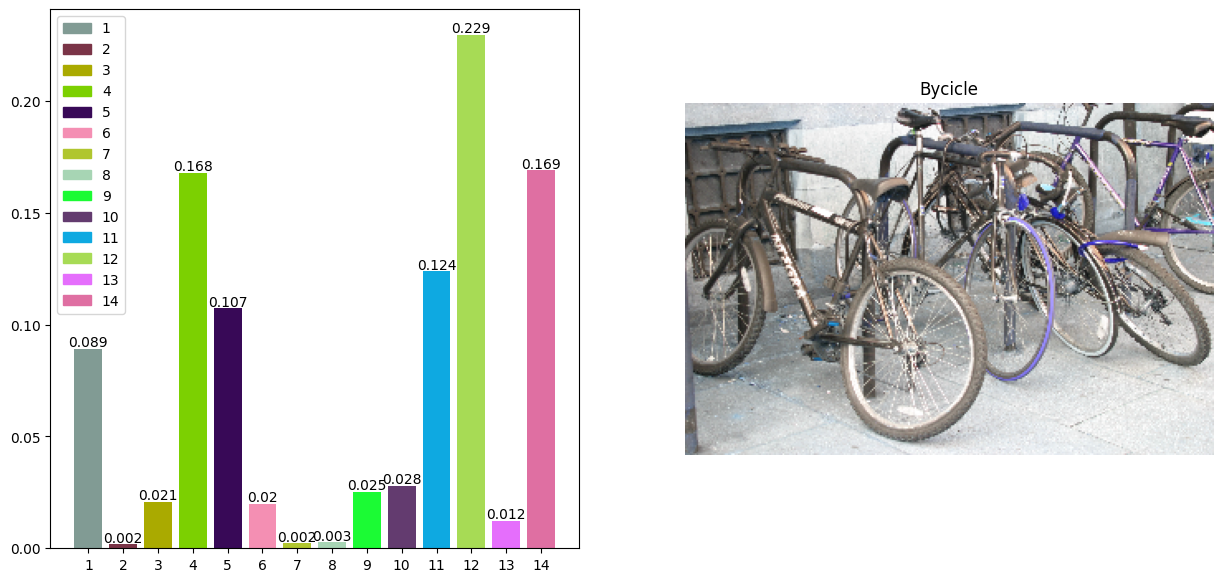

In [ ]:
data = lda.transform(vocabulary[231:]) # Here we are analyzing the last image of the dataset printed on the right.
print(f'The transformation through the Latent Dirichlet Allocation gave a \
probability distribution among the number of topics inserted, this \
vector of values obviously sums to 1 ≈ {np.sum(data[0])}')

fig = plt.figure(figsize=(15,7))
fig.add_subplot(1,2,1)
x=range(1,15)
x=[str(e) for e in x]
plt.bar(x, data[0], align='center', color=hex_colors)
for i in range(0, len(x)):
  plt.text(i,data[0][i]+0.001,round(data[0][i], 3), ha='center')
handles = [plt.Rectangle((0,0),1,1, color=hex_colors[i]) for i in range(0,len(x))]
plt.legend(handles, x, loc='best')
fig.add_subplot(1,2,2)
img = cv.imread('dataset/8_30_s.bmp')
plt.imshow(img)
plt.axis('off')
plt.title('Bycicle')

In [ ]:
np.argmax(data[0])

12

As we can see the LDA finded out that the clusters associated to the descriptors are associated mainly with the 12th component, now we will do this for the entire class of the image above and see if there is some sort of pattern (so considering the average of clusters manipulated through the LDA).

In [ ]:
topics_probs = lda.transform(vocabulary)
cates_topics=[]
for i in range(0,int(len(topics_probs)/29)):
  cates_topics.append(np.sum(topics_probs[(i*29):29+(i*29)], axis=0))

Naturally the mean among the first 29 images (belonging the same feature) is still summing to 1.0, we can see that there are diffenrent bars per category of images



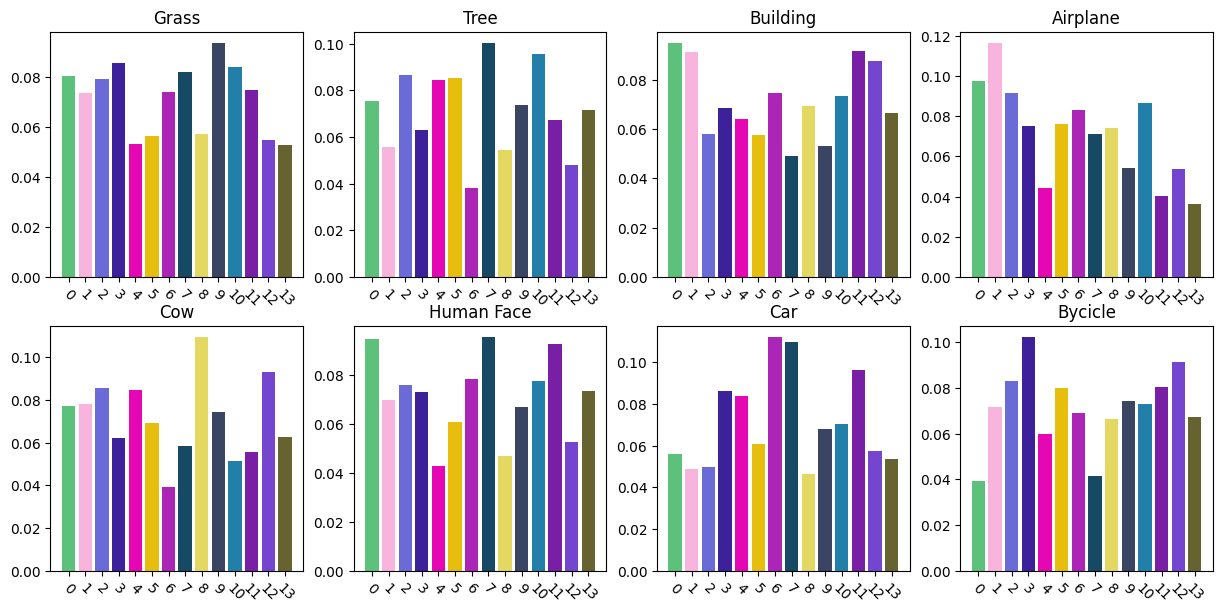

In [ ]:
print(f'Naturally the mean among the first 29 images (belonging the same feature) \
is still summing to {np.sum(cates_topics[0]/29)}, we can see that there are diffenrent \
bars per category of images\n')

categories = ['Grass', 'Tree', 'Building', 'Airplane', 'Cow', 'Human Face', 'Car', 'Bycicle']
fig = plt.figure(figsize=(15, 7))
rows = 2
columns = 4
for i, c in enumerate(cates_topics):
  fig.add_subplot(rows, columns, i+1)
  x=range(0,14)
  x=[str(e) for e in x]
  plt.bar(x, c/29, color=hex_colors)
  plt.xticks(rotation=45)
  plt.title(categories[i])

We can some sort relate a behaviour in the topics extracted for each subset of the dataset, indeed we can see that the cows have the highest presence of the 8th topic, instead the car the 6th and so on. We have to be careful with the topics that are common, indeed those could be common in the images or detected wrongly, like for the grass in which we can find a bit of everything even though there are just tufts of grass.

## LDA topic visualization

Here we are trying to use the LDA directly as a classifier fitting the graph on images (documents) that contains 100 patches (words) per each (so the data reduction performed on each descriptor of len 128) ∈ [0, 399].

In [ ]:
WHITE_BASE = False
if not os.path.exists('colored_results'):
  os.makedirs('colored_results')
dataset_imgs = os.listdir("dataset")
images_des = []
topic_predictions = []
KP_IMAGE=100
if not os.path.exists('results'):
  os.makedirs('results')
dataset_imgs = os.listdir("dataset")
for j, img_name in enumerate(dataset_imgs):
  if "GT" not in img_name:
    img = cv.imread('dataset/'+img_name)
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    kp = orb.detect(img,None)
    kp_s, des = sift.compute(img, kp[:KP_IMAGE])
    if WHITE_BASE:
      # Drawing BASE keypoints all in White
      gray = cv.drawKeypoints(gray, kp_s, gray, (255,255,255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    voc_img = gmm_model.predict(np.array(des).reshape(-1,128))
    # Topic extraction from the Probability distribution
    topics = ( # Here we are performing the LDA space transformation to detect the latent RVs
              lda.transform(
                  # But before it's necessary to convert the SIFT descriptor using the GMM into the vocabulary of items
                  gmm_model.predict(np.array(des).reshape(-1,128)).reshape(-1,100))) 
    for topic in topics.argsort()[0][:5]: # We represent only the first 3 topic
      representatives_kp = lda.components_[topic].argsort()[:-10 -1 : -1]
      clusters = np.unique(voc_img.take(representatives_kp))
      kp_ids = np.argwhere(np.isin(voc_img, clusters)).ravel()
      color = rgb_colors[topic]
      for id in kp_ids:
        gray = cv.drawKeypoints(gray, [kp_s[id]], gray, color, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.imwrite('colored_results/'+img_name.replace('.bmp','.jpg'),gray)

    topic_predictions.append(topics)

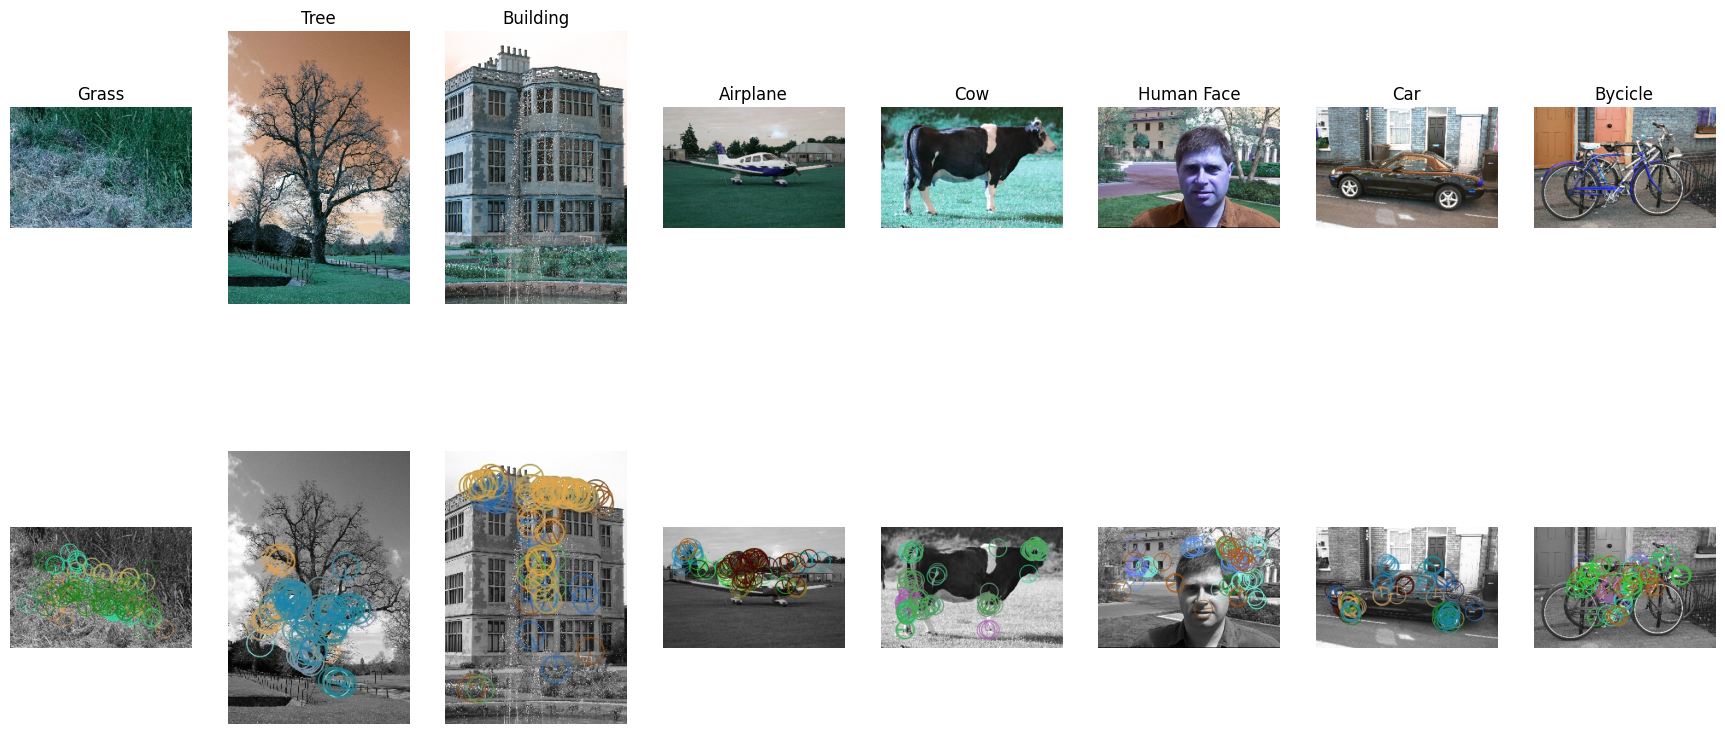

In [ ]:
plot_grids('colored_results')

Distribution of the maximum arguments find per groups of image divided by the topics.

In [ ]:
dist = []
classes = dict.fromkeys(range(14),0)

for i, img in enumerate(topic_predictions):
  if i%30 == 0:
    classes = dict.fromkeys(range(14),0)
    dist.append(classes)
  classes[img.argmax()]+=1
print(np.array(dist))

[{0: 3, 1: 1, 2: 2, 3: 3, 4: 0, 5: 1, 6: 3, 7: 3, 8: 3, 9: 4, 10: 2, 11: 2, 12: 1, 13: 2}
 {0: 1, 1: 1, 2: 6, 3: 1, 4: 3, 5: 4, 6: 0, 7: 3, 8: 0, 9: 1, 10: 5, 11: 1, 12: 1, 13: 3}
 {0: 3, 1: 4, 2: 1, 3: 2, 4: 2, 5: 1, 6: 1, 7: 0, 8: 3, 9: 2, 10: 2, 11: 2, 12: 4, 13: 3}
 {0: 4, 1: 4, 2: 3, 3: 2, 4: 1, 5: 3, 6: 2, 7: 2, 8: 4, 9: 1, 10: 1, 11: 0, 12: 2, 13: 1}
 {0: 2, 1: 3, 2: 2, 3: 1, 4: 4, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 4, 13: 2}
 {0: 4, 1: 1, 2: 2, 3: 3, 4: 0, 5: 2, 6: 2, 7: 4, 8: 0, 9: 1, 10: 3, 11: 2, 12: 1, 13: 5}
 {0: 1, 1: 1, 2: 2, 3: 5, 4: 1, 5: 0, 6: 3, 7: 4, 8: 1, 9: 1, 10: 2, 11: 6, 12: 2, 13: 1}
 {0: 2, 1: 3, 2: 3, 3: 3, 4: 3, 5: 1, 6: 1, 7: 0, 8: 1, 9: 2, 10: 4, 11: 1, 12: 4, 13: 2}]


# Classification

Here we are performing a sort of Random Search in order to find suitable parameters for the multi classification task of the images, wrapping up we are detecting and computing the descriptors for each image, creating a stack of descriptor to give to the GMM and cluster them in a set of 400 values that will form the Vocabulary, then giving each image represented as a set of 100 words of the vocabulary we are extracting the distribution of topics, finally we give this distribution to a Multinomial Naive Bayes Classifier in order to classify the image based on the probabilities of behave in a specific topic.

In [ ]:
params = {'KP_IMAGE': [100, 200, 300, 400],
          'COMPONENTS': [400, 450, 500, 600],
          'MAX_ITER_GMM': [100, 150, 200, 250],
          'MAX_ITER_LDA': [10, 15, 20, 25],
          'ALPHA': [0.5, 0.7, 1, 1.2]
          }
c, a, l, d, o, c1, a1, l1, d1, o1 = 0,0,0,0,0,0,0,0,0,0
TRIALS = 6
c_matrix = []
results = []
cls = ['Grass', 'Tree', 'Building', 'Airplane', 'Cow', 'Human Face', 'Car', 'Bycicle']

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from random import randint
from sklearn.metrics import precision_score, accuracy_score, make_scorer

scorers = {
        'precision_score': make_scorer(precision_score, average='macro'),
        'accuracy_score': make_scorer(accuracy_score, average='macro')
      }

orb = cv.ORB_create()
sift = cv.SIFT_create(0, 3, 0.04, 7, 1.6)

generated_y = target_generator()

dataset_imgs = os.listdir("dataset")

for i in range(0, TRIALS):
  while c1 == c and a1 ==a and l1 == l and d1 == d and o1 == o:
    c = randint(0, (len(params['KP_IMAGE'])-1))
    a = randint(0, (len(params['COMPONENTS'])-1))
    l = randint(0, (len(params['MAX_ITER_GMM'])-1))
    d = randint(0, (len(params['MAX_ITER_LDA'])-1))
    o = randint(0, (len(params['ALPHA'])-1))
  c1, a1, l1, d1, o1 = c, a, l, d, o
  descriptors=[]
  for img_name in dataset_imgs:
    if "GT" not in img_name:
      img = cv.imread('dataset/'+img_name)
      kp = orb.detect(img,None)
      kp_s, des = sift.compute(img,                    kp[:params['KP_IMAGE'][c]])
      descriptors.append(des)
  tensor = np.vstack(descriptors)

  gmm_model = GMM(                                       params['COMPONENTS'][a],
                  covariance_type='full', 
                  max_iter=                            params['MAX_ITER_GMM'][l],
                  random_state=0).fit(tensor)

  vocabulary = [gmm_model.predict(des_tensor[100*i:100*(i+1)]) 
                for i in range(0, 240)]

  lda = LatentDirichletAllocation(n_components=14,
                                  max_iter=            params['MAX_ITER_LDA'][d],
                                  verbose=1,
                                  random_state=0)
  topics_probs = lda.fit_transform(vocabulary)


  X, y = np.array(topics_probs).reshape(-1,14), generated_y
  X, y = shuffle(X, y, random_state=0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

  clf = MultinomialNB(alpha=                                  params['ALPHA'][o],
                      force_alpha=True)

  y_pred = clf.fit(X_train, y_train).predict(X_test)

  c_matrix.append(confusion_matrix(y_test, y_pred))

  results.append(cross_validate(clf, X, y, cv=5, 
                                scoring=scorers,
                                return_train_score=True))

In [ ]:
print(np.array(results))

In [ ]:
for i, c in enumerate(c_matrix):
  disp = ConfusionMatrixDisplay(confusion_matrix=c,display_labels=cls)
  disp.plot()
  plt.grid(False)
  plt.xticks(rotation='vertical')
  plt.title('This is the run n ' + str(i+1))

## Conclusion
The LDA helps in reconstructing the data creating a variable that maps the complex behave of the images, more or less the main topics detected on the clusters of the descriptors are focusing on the right subjects and the results of the classifier on top of the probability distribution.